# Seq2Seq - Encoder/Decoder networks
In this exercise we'll have a deeper look into the ability to use multiple RNN's to infer and generate sequences of data.
Specifically we will implement a Encoder-Decoder RNN based for a simple sequence to sequence translation task.
This type of models have shown impressive performance in Neural Machine Translation and Image Caption generation. 

In the encoder-decoder structure one RNN (blue) encodes the input into a hidden representation, and a second RNN (red) uses this representation to predict the target values.
An essential step is deciding how the encoder and decoder should communicate.
In the simplest approach you use the last hidden state of the encoder to initialize the decoder.
This is what we will do in this notebook, as shown here:

![](./images/enc-dec.png)

In this exercise we will translate from the words of number (e.g. 'nine') to the actual number (e.g. '9').
The input for the Encoder RNN consists of words defining the number, whilst the output of such an encoding serves as input for the Decoder RNN that aims to generate generate a number. 
Our dataset is generated and consists of numbers and an End-of-Sentence (EOS) character ('#'). The data we want to generate should be like follows:

```
Examples: 
prediction  |  input
991136#00 	 nine nine one one three six
81771#000 	 eight one seven seven one
3519614#0 	 three five one nine six one four
26656#000 	 two six six five six
60344#000 	 six zero three four four
162885#00 	 one six two eight eight five
78612625# 	 seven eight six one two six two five
9464710#0 	 nine four six four seven one zero
191306#00 	 one nine one three zero six
10160378# 	 one zero one zero six three seven eight
```

Let us define the space of characters and numbers to be learned with the networks:

```
Number of valid characters: 27
'0'=0,	'1'=1,	'2'=2,	'3'=3,	'4'=4,	'5'=5,	'6'=6,	'7'=7,	'8'=8,	'9'=9,	'#'=10,	' '=11,	'e'=12,	'g'=13,	'f'=14,	'i'=15,	'h'=16,	'o'=17,	'n'=18,	's'=19,	'r'=20,	'u'=21,	't'=22,	'w'=23,	'v'=24,	'x'=25,	'z'=26,	
Stop/start character = #
```

All represented characters and numbers as characters, gets mapped to an integer from 0-26. Our total space of valid characters consists of 27.

In [1]:
from data_generator import generate
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from data_generator import generate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in use:", device)

NUM_INPUTS = 27 #No. of possible characters
NUM_OUTPUTS = 11  # (0-9 + '#')

### Hyperparameters and general configs
MAX_SEQ_LEN = 8
MIN_SEQ_LEN = 5
BATCH_SIZE = 8
TRAINING_SIZE = 8000
LEARNING_RATE = 0.003

# Hidden size of enc and dec need to be equal if last hidden of encoder becomes init hidden of decoder
# Otherwise we would need e.g. a linear layer to map to a space with the correct dimension
NUM_UNITS_ENC = NUM_UNITS_DEC = 48
TEST_SIZE = 200
EPOCHS = 10
TEACHER_FORCING = False

assert TRAINING_SIZE % BATCH_SIZE == 0

Device in use: cpu


For this exercise we won´t worry about data generation, but utilise a built function for this purpose. The function generates random data constained by the 27 characters described above.

The encoder takes as input the embedded text strings generated from the *generate* function as given here above ie. 'nine' would become [18 15 18 12].
Sequeneces are generated at random given settings of minima and maxima length, constrained by the dimensions of the two RNN´s architecture.
We may visualise a subset of the data generated by running the command below

In [2]:
!python3 ./data_generator.py

Generated batch length 3 from 3 iterations
input types: int32 int32 int32 int32 int32
Number of valid characters: 27
'0'=0,	'1'=1,	'2'=2,	'3'=3,	'4'=4,	'5'=5,	'6'=6,	'7'=7,	'8'=8,	'9'=9,	'#'=10,	's'=11,	'x'=12,	'w'=13,	'i'=14,	'f'=15,	'e'=16,	'v'=17,	'h'=18,	'o'=19,	'n'=20,	'g'=21,	'z'=22,	' '=23,	'r'=24,	't'=25,	'u'=26,	
Stop/start character = #

SAMPLE 0
TEXT INPUTS:			 seven zero one one
ENCODED INPUTS:			 [11 16 17 16 20 23 22 16 24 19 23 19 20 16 23 19 20 16]
INPUTS SEQUENCE LENGTH:	 18
TEXT TARGETS INPUT:		 #7011
TEXT TARGETS OUTPUT:	 7011#
ENCODED TARGETS INPUT:	 [10  7  0  1  1]
ENCODED TARGETS OUTPUT:	 [ 7  0  1  1 10]
TARGETS SEQUENCE LENGTH: 5
TARGETS MASK:			 [1. 1. 1. 1. 1.]

SAMPLE 1
TEXT INPUTS:			 one two
ENCODED INPUTS:			 [19 20 16 23 25 13 19  0  0  0  0  0  0  0  0  0  0  0]
INPUTS SEQUENCE LENGTH:	 7
TEXT TARGETS INPUT:		 #12
TEXT TARGETS OUTPUT:	 12#
ENCODED TARGETS INPUT:	 [10  1  2  0  0]
ENCODED TARGETS OUTPUT:	 [ 1  2 10  0  0]
TARGETS SEQUENCE LENGTH: 3
TARGE

## Let's define the two RNN's



In [3]:
isGru = False

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, self.hidden_size)
        if isGru:
            rnn = nn.GRU
        else:
            rnn = nn.LSTM
        self.rnn = rnn(self.hidden_size, self.hidden_size, batch_first=True)
        
    def forward(self, inputs, hidden):
        # Input shape [batch, seq_in_len]z
        inputs = inputs.long()

        # Embedded shape [batch, seq_in_len, embed]
        embedded = self.embedding(inputs)
        
        # Output shape [batch, seq_in_len, embed]
        # Hidden shape [1, batch, embed], last hidden state of the GRU cell
        # We will feed this last hidden state into the decoder
        output, hidden = self.rnn(embedded, hidden)
        return output, hidden

    def init_hidden(self, batch_size):
        if isGru:
            init = torch.zeros(1, batch_size, self.hidden_size, device=device)
        else:
            init = (torch.zeros(1, batch_size, self.hidden_size, device=device),
                    torch.zeros(1, batch_size, self.hidden_size, device=device))
        return init


In [4]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        #rnn = nn.GRU
        rnn = nn.LSTM
        self.rnn = rnn(self.hidden_size, self.hidden_size, batch_first=True)
        
    def forward(self, inputs, hidden, output_len, teacher_forcing=False):
        # Input shape: [batch, output_len]
        # Hidden shape: [seq_len=1, batch_size, hidden_dim] (the last hidden state of the encoder)

        if teacher_forcing:
            dec_input = inputs
            embed = self.embedding(dec_input)   # shape [batch, output_len, hidden_dim]
            out, hidden = self.rnn(embed, hidden)
            out = self.out(out)  # linear layer, out has now shape [batch, output_len, output_size]
            output = F.log_softmax(out, -1)
        else:
            # Take the EOS character only, for the whole batch, and unsqueeze so shape is [batch, 1]
            # This is the first input, then we will use as input the GRU output at the previous time step
            dec_input = inputs[:, 0].unsqueeze(1)

            output = []
            for i in range(output_len):
                out, hidden = self.rnn(self.embedding(dec_input), hidden)
                out = self.out(out)  # linear layer, out has now shape [batch, 1, output_size]
                out = F.log_softmax(out, -1)
                output.append(out.squeeze(1))
                out_symbol = torch.argmax(out, dim=2)   # shape [batch, 1]
                dec_input = out_symbol   # feed the decoded symbol back into the recurrent unit at next step

            output = torch.stack(output).permute(1, 0, 2)  # [batch_size x seq_len x output_size]

        return output

The learned representation from the *Encoder* gets propagated to the *Decoder* as the final hidden layer in the *Encoder* network is set as initialisation for the *Decoder*'s first hidden layer.

In [5]:
def forward_pass(encoder, decoder, x, t, t_in, criterion, max_t_len, teacher_forcing):
    """
    Executes a forward pass through the whole model.

    :param encoder:
    :param decoder:
    :param x: input to the encoder, shape [batch, seq_in_len]
    :param t: target output predictions for decoder, shape [batch, seq_t_len]
    :param criterion: loss function
    :param max_t_len: maximum target length

    :return: output (after log-softmax), loss, accuracy (per-symbol)
    """
    # Run encoder and get last hidden state (and output)
    batch_size = x.size(0)
    enc_h = encoder.init_hidden(batch_size)
    enc_out, enc_h = encoder(x, enc_h)

    dec_h = enc_h  # Init hidden state of decoder as hidden state of encoder
    dec_input = t_in
    out = decoder(dec_input, dec_h, max_t_len, teacher_forcing)
    out = out.permute(0, 2, 1)
    # Shape: [batch_size x num_classes x out_sequence_len], with second dim containing log probabilities

    loss = criterion(out, t)
    pred = get_pred(log_probs=out)
    accuracy = (pred == t).type(torch.FloatTensor).mean()
    return out, loss, accuracy


In [6]:
def train(encoder, decoder, inputs, targets, targets_in, criterion, enc_optimizer, dec_optimizer, epoch, max_t_len):
    encoder.train()
    decoder.train()
    save_acc = [] #### added to be able to plot the results
    
    for batch_idx, (x, t, t_in) in enumerate(zip(inputs, targets, targets_in)):
        
        
        # INSERT YOUR CODE HERE

        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()
        
        x = x.long()
        t = t.long()
        t_in = t_in.long()
    
        out, loss, accuracy = forward_pass(encoder, decoder, x, t, t_in, criterion, max_t_len,
                                           teacher_forcing=TEACHER_FORCING)
        loss.backward()
        enc_optimizer.step()
        dec_optimizer.step()
        
        # END CODE
        
        if batch_idx % 200 == 0:
            print('Epoch {} [{}/{} ({:.0f}%)]\tTraining loss: {:.4f} \tTraining accuracy: {:.1f}%'.format(
                epoch, batch_idx * len(x), TRAINING_SIZE,
                100. * batch_idx * len(x) / TRAINING_SIZE, loss.item(),
                100. * accuracy.item()))
            save_acc.append(accuracy) #### added to be able to plot the results
            
    return save_acc #### added to be able to plot the results

In [7]:
def test(encoder, decoder, inputs, targets, targets_in, criterion, max_t_len):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        inputs = inputs.to(device)
        targets = targets.long().to(device)
        targets_in = targets_in.long().to(device)
        out, loss, accuracy = forward_pass(encoder, decoder, inputs, targets, targets_in, criterion, max_t_len,
                                           teacher_forcing=TEACHER_FORCING)
    return out, loss, accuracy

In [8]:
def numbers_to_text(seq):
    return "".join([str(to_np(i)) if to_np(i) != 10 else '#' for i in seq])

def to_np(x):
    return x.cpu().numpy()

def get_pred(log_probs):
    """
    Get class prediction (digit prediction) from the net's output (the log_probs)
    :param log_probs: Tensor of shape [batch_size x n_classes x sequence_len]
    :return:
    """
    return torch.argmax(log_probs, dim=1)

In [9]:
encoder = EncoderRNN(NUM_INPUTS, NUM_UNITS_ENC).to(device)
decoder = DecoderRNN(NUM_UNITS_DEC, NUM_OUTPUTS).to(device)
enc_optimizer = optim.RMSprop(encoder.parameters(), lr=LEARNING_RATE)
dec_optimizer = optim.RMSprop(decoder.parameters(), lr=LEARNING_RATE)
criterion = nn.NLLLoss()

# Get training set
inputs, _, targets_in, targets, targets_seqlen, _, _, _, text_targ = generate(TRAINING_SIZE, min_len=MIN_SEQ_LEN, max_len=MAX_SEQ_LEN)
max_target_len = max(targets_seqlen)
inputs = torch.tensor(inputs)
targets = torch.tensor(targets)
targets_in = torch.tensor(targets_in)
unique_text_targets = set(text_targ)

# Get validation set
val_inputs, _, val_targets_in, val_targets, val_targets_seqlen, _, val_text_in, _, val_text_targ = \
    generate(TEST_SIZE, min_len=MIN_SEQ_LEN, max_len=MAX_SEQ_LEN, invalid_set=unique_text_targets)
val_inputs = torch.tensor(val_inputs)
val_targets = torch.tensor(val_targets)
val_targets_in = torch.tensor(val_targets_in)
max_val_target_len = max(val_targets_seqlen)
test(encoder, decoder, val_inputs, val_targets, val_targets_in, criterion, max_val_target_len)

# Split training set in batches
inputs = [inputs[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] for i in range(TRAINING_SIZE // BATCH_SIZE)]
targets = [targets[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] for i in range(TRAINING_SIZE // BATCH_SIZE)]
targets_in = [targets_in[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] for i in range(TRAINING_SIZE // BATCH_SIZE)]

train_acc, valid_acc = [], [] ####

# Quick and dirty - just loop over training set without reshuffling
for epoch in range(1, EPOCHS + 1):
    _train_acc = train(encoder, decoder, inputs, targets, targets_in, criterion, enc_optimizer, dec_optimizer, epoch, max_target_len)
    _, loss, accuracy = test(encoder, decoder, val_inputs, val_targets, val_targets_in, criterion, max_val_target_len)
    
    train_acc.append(_train_acc) ####
    valid_acc.append(accuracy) ####
    
    print('\nTest set: Average loss: {:.4f} \tAccuracy: {:.3f}%\n'.format(loss, accuracy.item()*100.))

    # Show examples
    print("Examples: prediction | input")
    out, _, _ = test(encoder, decoder, val_inputs[:10], val_targets[:10], val_targets_in[:10], criterion, max_val_target_len)
    pred = get_pred(out)
    pred_text = [numbers_to_text(sample) for sample in pred]
    for i in range(10):
        print(pred_text[i], "\t", val_text_in[i])
    print()

Generated batch length 8000 from 8000 iterations
Generated batch length 200 from 200 iterations
Epoch 1 [0/8000 (0%)]	Training loss: 2.4265 	Training accuracy: 11.1%
Epoch 1 [1600/8000 (20%)]	Training loss: 2.2337 	Training accuracy: 25.0%
Epoch 1 [3200/8000 (40%)]	Training loss: 1.9534 	Training accuracy: 27.8%
Epoch 1 [4800/8000 (60%)]	Training loss: 1.6414 	Training accuracy: 40.3%
Epoch 1 [6400/8000 (80%)]	Training loss: 1.9531 	Training accuracy: 29.2%

Test set: Average loss: 1.7483 	Accuracy: 34.444%

Examples: prediction | input
77777777# 	 four eight nine six six three three seven
383333#00 	 zero seven eight nine eight five
7875907#0 	 eight three one two eight five two
0402226## 	 two four five nine five seven two
02222226# 	 zero zero zero zero zero one nine
7877777## 	 eight eight eight eight seven five five
77777777# 	 eight three four four three nine two five
02226#000 	 two five zero six seven
555226##0 	 nine nine two three six five
02226#000 	 two six four one four

E

Epoch 10 [1600/8000 (20%)]	Training loss: 0.6355 	Training accuracy: 70.8%
Epoch 10 [3200/8000 (40%)]	Training loss: 0.5540 	Training accuracy: 80.6%
Epoch 10 [4800/8000 (60%)]	Training loss: 0.4928 	Training accuracy: 81.9%
Epoch 10 [6400/8000 (80%)]	Training loss: 0.5228 	Training accuracy: 83.3%

Test set: Average loss: 1.1863 	Accuracy: 67.556%

Examples: prediction | input
84870337# 	 four eight nine six six three three seven
079985#00 	 zero seven eight nine eight five
8322852#0 	 eight three one two eight five two
2955972#0 	 two four five nine five seven two
00490009# 	 zero zero zero zero zero one nine
88825855# 	 eight eight eight eight seven five five
88333855# 	 eight three four four three nine two five
26607##00 	 two five zero six seven
691365#00 	 nine nine two three six five
26144#000 	 two six four one four



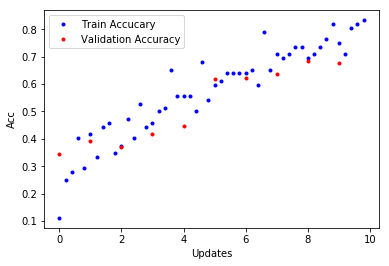

In [13]:
#### to plot the results
import matplotlib.pyplot as plt
import numpy as np


train_acc_1 = []
for e in range(0,EPOCHS):
    for n in range(0,5):
        train_acc_1.append(train_acc[e][n])

x_train_acc = np.arange(0,EPOCHS,0.2)
x_valid_acc = range(0,EPOCHS)

fig = plt.figure()
plt.plot(x_train_acc, train_acc_1, 'b.', x_valid_acc, valid_acc, 'r.')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')
plt.show()

# Exercise:

1. Implement missing code for the network in the *train* function. Your validation accuracy is expected to be <20% at this point.
2. These networks implement the GRU-gates. Implement an alternative control utilising a memory mechanism (Hint: LSTM). What do you experience? 
3. There are some parameters in the model that may be optimized further, what could they be? Achieve >90% validation accuracy.

# Answers:
For all tests this parameters were used:<br>
    - epochs = 10
    - lr = 0.003 
    - optimizer = RMSprop
    
1. In the training function for the GRU-gates we added:
    - x = x.long()
    - t = t.long()
    - t_in = t_in.long()
    - out, loss, accuracy = forward_pass(...)
    - loss.backward()
    <br>
    
    <br> First of all, the input and the targets should be type 'long'. After that, 'forward_pass' compute the encoder GRU and sets its output as onput for the decoder GRU.

    The accuracy was too low, between 9% and 16% as expected.

<br><br>

3. We skiped the second step and decided to implement the optimizer for both encoder and decoder networks with GRU-gates:
    - enc_optimizer.zero_grad()
    - dec_optimizer.zero_grad()
    
    - **#code from question 1**
    
    - enc_optimizer.step()
    - dec_optimizer.step()
    <br>With theese small changes the accuracy climbs up to 70-80%.
    
<br><br>

2. Now it is turn to switch from GRU to LSTM
    - Without optimizers, the accuracy is 3-14%
    - With the same optimizers as before we got the same results, between 70-80% of accuracy.

    Trying now to improve the accuracy to more than 90%:
    - With optimizers and changing the hidden-layer from 48 to 80 units we got an average of 75% but with peaks of 90-95%.<br>
    
    Maybe changing other parameters such as the learning rate or the optimizer would have helped achieving the desired accuracy but we havn't tested it. We noticed in the graph that is going straight up, so we conclude that with more epoch it will stabilize in a higher percentage.

<br><br><br>

## Book exercise:

**Answer:**

### Excercise from Chapter 3 - Derivative of the Sigmoid Function

The sigmoid function is given by

$\sigma (z) = \frac{1}{1 + e^{-z}}$

where the derivative is

$\frac{\delta\sigma}{\delta z}(z) = \sigma (z)(1 - \sigma (z))$

** Proof **
We define $x(z) = 1 + e^{-z}$ so that $\sigma(z) = \frac{1}{x(z)}$. Applying the chain-rule we get

$\frac{\delta\sigma}{\delta z} = \frac{\delta\sigma}{\delta x}(x(z)) \frac{\delta x}{\delta z}$

where

$ \frac{\delta\sigma}{\delta x}(x) = \frac{-1}{x^2}$ and $\frac{\delta x}{\delta z}(z) = -e^{-z}$

By insertion we get

$ \frac{\delta \sigma}{\delta z}(z) = -e^{-z}\frac{-1}{x(z)^2} = \frac{1}{(1 + e^{-z})^2}e^{-z} = \sigma(z)\frac{e^{-z}}{1 + e^{-z}} = \sigma(z)(\frac{e^{-z} + 1}{1 + e^{-z}} - \frac{1}{1 + e^{-z}}) = \sigma(z)(1 - \sigma(z))$
...